In [26]:
import dynesty
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate
from scipy.signal import welch

# import the PyCBC package
import pycbc.waveform
from pycbc import types
import dynesty.plotting as dyplot
import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal as _lal


In [27]:
# define the inner product
def inner_product(h1, h2, Sn, df):
    """Calculate the inner product of two waveforms h1 and h2."""
    return np.abs(np.sum(np.conj(h1) * h2 / Sn)) * df

# define a function that calculates the SNR:
def SNR(a, b, Sn, frequency_spacing):
    """
    Calculate the SNR of a signal a in the presence of noise b.

    SNR = sqrt(4 * <a|b>), where <a|b> is the inner product of a and b and the noise power spectrum Sn.

    Parameters
    ----------
    a : array_like
        The signal template
    b : array_like
        The noisy data
    Sn : array_like
        The noise power spectrum
    frequency_spacing : float
        The frequency spacing of the data

    Returns
    -------
    float
        The signal-to-noise ratio of the signal a in the noisy data b
    """
    # 
    inner = inner_product(a, b, Sn, frequency_spacing)
    return np.sqrt(inner * 4)

In [28]:
end_of_signal = 171.8291015625
signal_duraton = 8.0

In [29]:
# define the F_plus and F_cross functions
def F(theta,phi,psi,polarisation = "plus"):
    if polarisation == "plus":
        return (1+np.cos(theta)**2)/2 * np.cos(2*phi) * np.cos(2*psi) + np.cos(theta) * np.sin(2*phi) * np.sin(2*psi)
    else:
        return (1+np.cos(theta)**2)/2 * np.cos(2*phi) * np.sin(2*psi) - np.cos(theta) * np.sin(2*phi) * np.cos(2*psi)


In [30]:
# defien a waveform model
def waveform_model(params: dict[str, float],
                   frequency_array: np.array) -> tuple[np.array, np.array]:
    """
    A wrapper function that takes a list of BBH parameters and returns teo frequency arrays and the frequency-domain waveform
    """
    
    # unpack the parameters
    m1 = params["mass1"]
    m2 = params["mass2"]
    chi1 = params["spin1z"]
    chi2 = params["spin2z"]
    DL = params["distance"]
    iota = params["inclination"]
    phi_ref = params["coa_phase"]

    # define the frequency array
    f_lower = frequency_array[0]
    
    # define the waveform model
    hp, hc = pycbc.waveform.get_fd_waveform(approximant="IMRPhenomD",
                                            mass1=m1,
                                            mass2=m2,
                                            spin1z = chi1,
                                            spin2z = chi2,
                                            distance=DL,
                                            inclination=iota,
                                            coa_phase=phi_ref,
                                            f_lower=f_lower,
                                            delta_f=frequency_array[1]-frequency_array[0])
    
    return (hp, hc)


In [31]:
# define the frequency array
f_lower = 10
f_upper = 1024
delta_f = 1.0/16
frequency_array = np.arange(f_lower, f_upper, delta_f)

# initial the parameters
initial_params = {"mass1": 30.0,
                    "mass2": 30.0,
                    "spin1z": 0.0,
                    "spin2z": 0.0,
                    "distance": 500.0,
                    "inclination": np.pi/3,
                    "coa_phase": 0.0,
                    "theta": 0.0,
                    "phi": 0.0,
                    "psi": 0.0}




In [32]:
# read the expected PSD
ASD_expected = np.loadtxt('data/ASD.txt')
ASD_expected_freq = ASD_expected[:,0]
ASD_expected_value = ASD_expected[:,1]
PSD_expected_value = ASD_expected_value**2

# interpolate the PSD to the frequency array
PSD_expected_value = interpolate.interp1d(ASD_expected_freq, PSD_expected_value, kind='linear')(frequency_array)

In [33]:
# read testdata 
data = np.loadtxt('data/data.txt')
data_value = data[:,1]
data_time = data[:,0]

# get the sampling rate 
sampling_rate = 1/(data_time[1] - data_time[0])

# copy the original data
data_value_orginal = data_value.copy()

# filter the data such that it centered around the signal with the appropriate duration
t_end = end_of_signal
t_start = t_end - signal_duraton
data_value = data_value[(data_time >= t_start) & (data_time <= t_end)]
data_time = data_time[(data_time >= t_start) & (data_time <= t_end)]

# shif the time domain data by 
data_time = data_time - end_of_signal

In [34]:
# frequency array for the data
f_array = np.linspace(f_lower, f_upper, int((f_upper - f_lower)/delta_f))

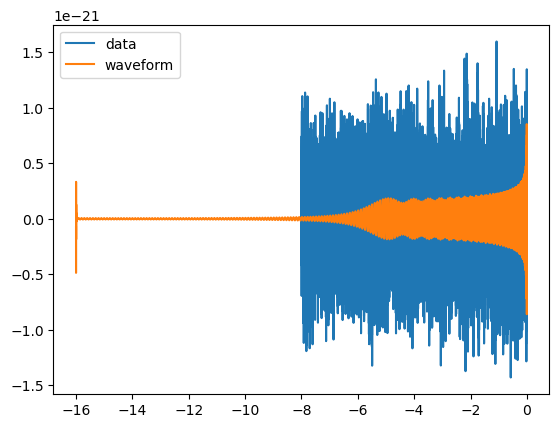

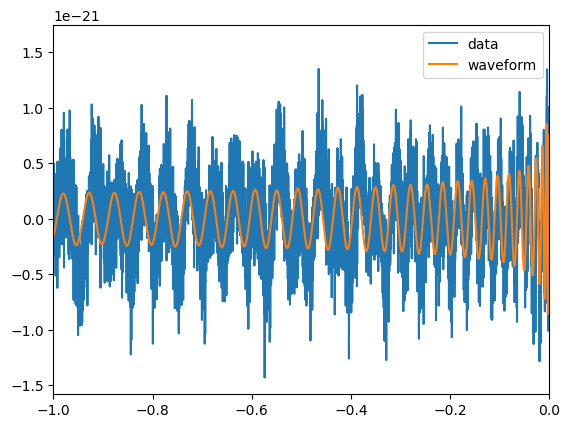

In [35]:
# generate the waveform
hp, hc = waveform_model(initial_params, frequency_array)

# get time series data 
hp_time = hp.to_timeseries()
hc_time = hc.to_timeseries()

# h = hp * F_plus + hc * F_cross
h = hp_time * F(initial_params["theta"], initial_params["phi"], initial_params["psi"], "plus") + hc_time * F(initial_params["theta"], initial_params["phi"], initial_params["psi"], "cross")

# get the frequency array of the waveform
h_freq = hp.sample_frequencies

# cut the waveform to the same length as the data   
# h = h[(hp_time.sample_times >= -4)]
h_time = hp_time.sample_times
# h_time = h_time[(hp_time.sample_times >= -4)]

# fill in the zeros at the end of the waveform
zero_value = np.zeros(len(data_time) - len(h_time))
zero_time = np.linspace(h_time[-1], data_time[-1], len(zero_value))

h = np.concatenate((h, zero_value))
h_time = np.concatenate((h_time, zero_time))

# plot h and data
plt.figure()
plt.plot(data_time, data_value, label="data")
plt.plot(h_time, h, label="waveform")
plt.legend()
plt.show()

# plot the data from -1 to 0s 
plt.figure()
plt.plot(data_time, data_value, label="data")
plt.plot(h_time, h, label="waveform")
plt.xlim(-1, 0)
plt.legend()
plt.show()


In [36]:
from pycbc import types

In [37]:
# the time series of the data
data_time_series = types.TimeSeries(data_value, delta_t=1/sampling_rate)

# the frequency series of the data
data_frequency_series = data_time_series.to_frequencyseries()

# the frequency array of the data
data_frequency = data_frequency_series.sample_frequencies

# intrapolate the data to the frequency array of the template
data_interpolate = interpolate.interp1d(data_frequency, data_frequency_series, kind='linear', fill_value='extrapolate')(f_array)

-4.039895799384766 7.537932194844957


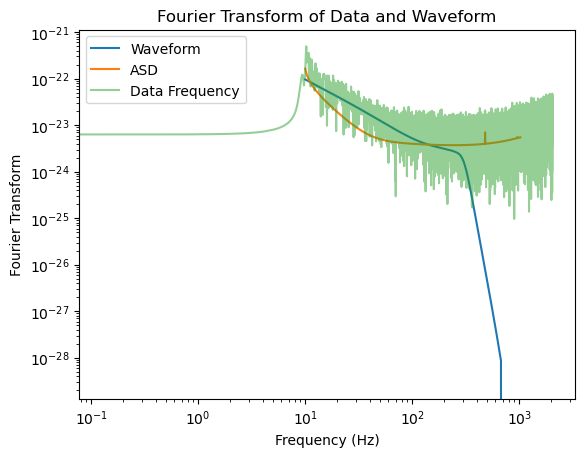

In [38]:
# generate the waveform
hp, hc = waveform_model(initial_params, frequency_array)
h_freq = hp.sample_frequencies

# interpolate the waveform to the frequency array
hp = interpolate.interp1d(h_freq, hp, kind='linear', fill_value='extrapolate')(f_array)

residual = data_interpolate - hp
SNR_residual = SNR(residual, residual, PSD_expected_value, delta_f) - SNR(data_interpolate, data_interpolate, PSD_expected_value, delta_f)
likelihood = np.exp(-0.5 * SNR_residual)
print (SNR_residual, likelihood)

# plot data_fft and h
plt.figure()
plt.loglog(f_array, np.abs(hp), label='Waveform')
plt.loglog(f_array, np.sqrt(PSD_expected_value), label='ASD')
plt.loglog(data_frequency, np.abs(data_frequency_series), label='Data Frequency', alpha=0.5)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Fourier Transform')
plt.title('Fourier Transform of Data and Waveform')
plt.legend()
plt.show()

In [39]:
# define the likelihood function
def likelihood(params: list[float],
                ) -> float:
    """
    A function that takes a list of BBH parameters and returns the log-likelihood of the data given the model
    """

    # pack the parameters
    params = {"mass1": params[0],
                "mass2": params[1],
                "spin1z": params[2],
                "spin2z": params[3],
                "distance": params[4],
                "inclination": params[5],
                "coa_phase": params[6],
                "theta": params[7],
                "phi": params[8],
                "psi": params[9]
    }
    params = {**initial_params, **params}
    # generate the waveform

    hp, hc = waveform_model(params, frequency_array)
    h_freq = hp.sample_frequencies

    # h = hp * F(0,0,0,"plus") + hc * F(0,0,0,"cross")
    h = hp * F(params["theta"], params["phi"], params["psi"], "plus") + hc * F(params["theta"], params["phi"], params["psi"], "cross")

    # interpolate the PSD of the data to the frequency array
    h = interpolate.interp1d(h_freq, h, kind='linear', fill_value='extrapolate')(f_array)
    
    # residual 
    residual_fft = data_interpolate - h
    
    # calculate the SNR of the residual
    inner = inner_product(residual_fft, residual_fft, PSD_expected_value, delta_f)
    likelihood = -0.5 * inner

    return likelihood



In [40]:
# prior transform function that is compatible with dynesty
def prior_transform(u):
    """
    A function that maps a unit cube to the parameter space
    """

    # define the BBH parameters
    params = {}
       
    # Define the ranges for the log-uniform priors
    min_mass, max_mass = 5, 100 # mass range in solar masses
    min_dist, max_dist = 10, 1000 # distance range in Mpc
    
    # Log-uniform prior for mass1 and mass2
    params["mass1"] = 10**(np.log10(min_mass) + u[0] * (np.log10(max_mass) - np.log10(min_mass)))
    params["mass2"] = 10**(np.log10(min_mass) + u[1] * (np.log10(max_mass) - np.log10(min_mass)))

    # uniform prior for mass1 and mass2
    # params["mass1"] = min_mass + u[0] * (max_mass - min_mass)
    # params["mass2"] = min_mass + u[1] * (max_mass - min_mass)
    
    # # Uniform prior for spins
    params["spin1z"] = -1 + 2 * u[2]
    params["spin2z"] = -1 + 2 * u[3]
    
    # Log-uniform prior for distance
    params["distance"] = 10**(np.log10(min_dist) + u[4] * (np.log10(max_dist) - np.log10(min_dist)))

    # uniform prior for distance
    # params["distance"] = min_dist + u[4] * (max_dist - min_dist)
    
    # uniform cos(iota)
    x = -1 + 2 * u[5]
    params["inclination"] = np.arccos(x)
    
    # uniform coa_phase
    params["coa_phase"] = -np.pi + 2 * np.pi * u[6]

    # uniform theta
    params["theta"] = np.pi * u[7]

    # uniform phi
    params["phi"] =  -np.pi + 2 * np.pi * u[8]

    # uniform psi
    params["psi"] =  -np.pi + 2 * np.pi * u[9]

    # conver to a list
    params = list(params.values())

    return params

In [41]:
# determine the number of dimensions
ndim = 10

In [42]:
sampler = dynesty.NestedSampler(likelihood, prior_transform, ndim)
sampler.run_nested(checkpoint_file = 'checkpoint.pkl')

10748it [34:13,  5.23it/s, +500 | bound: 125 | nc: 1 | ncall: 286547 | eff(%):  3.932 | loglstar:   -inf < -1360.012 <    inf | logz: -1380.836 +/-  0.205 | dlogz:  0.001 >  0.509]


In [43]:
results = sampler.results

In [44]:
from dynesty import utils as dyfunc

samples, weights = results.samples, results.importance_weights()
mean, cov = dyfunc.mean_and_cov(samples, weights)

In [45]:
# save the sampler 
import pickle

# create a directory to save the results
import os
if not os.path.exists('result'):
    os.makedirs('result')
    

with open('result/sampler.pkl', 'wb') as f:
    pickle.dump(sampler, f)

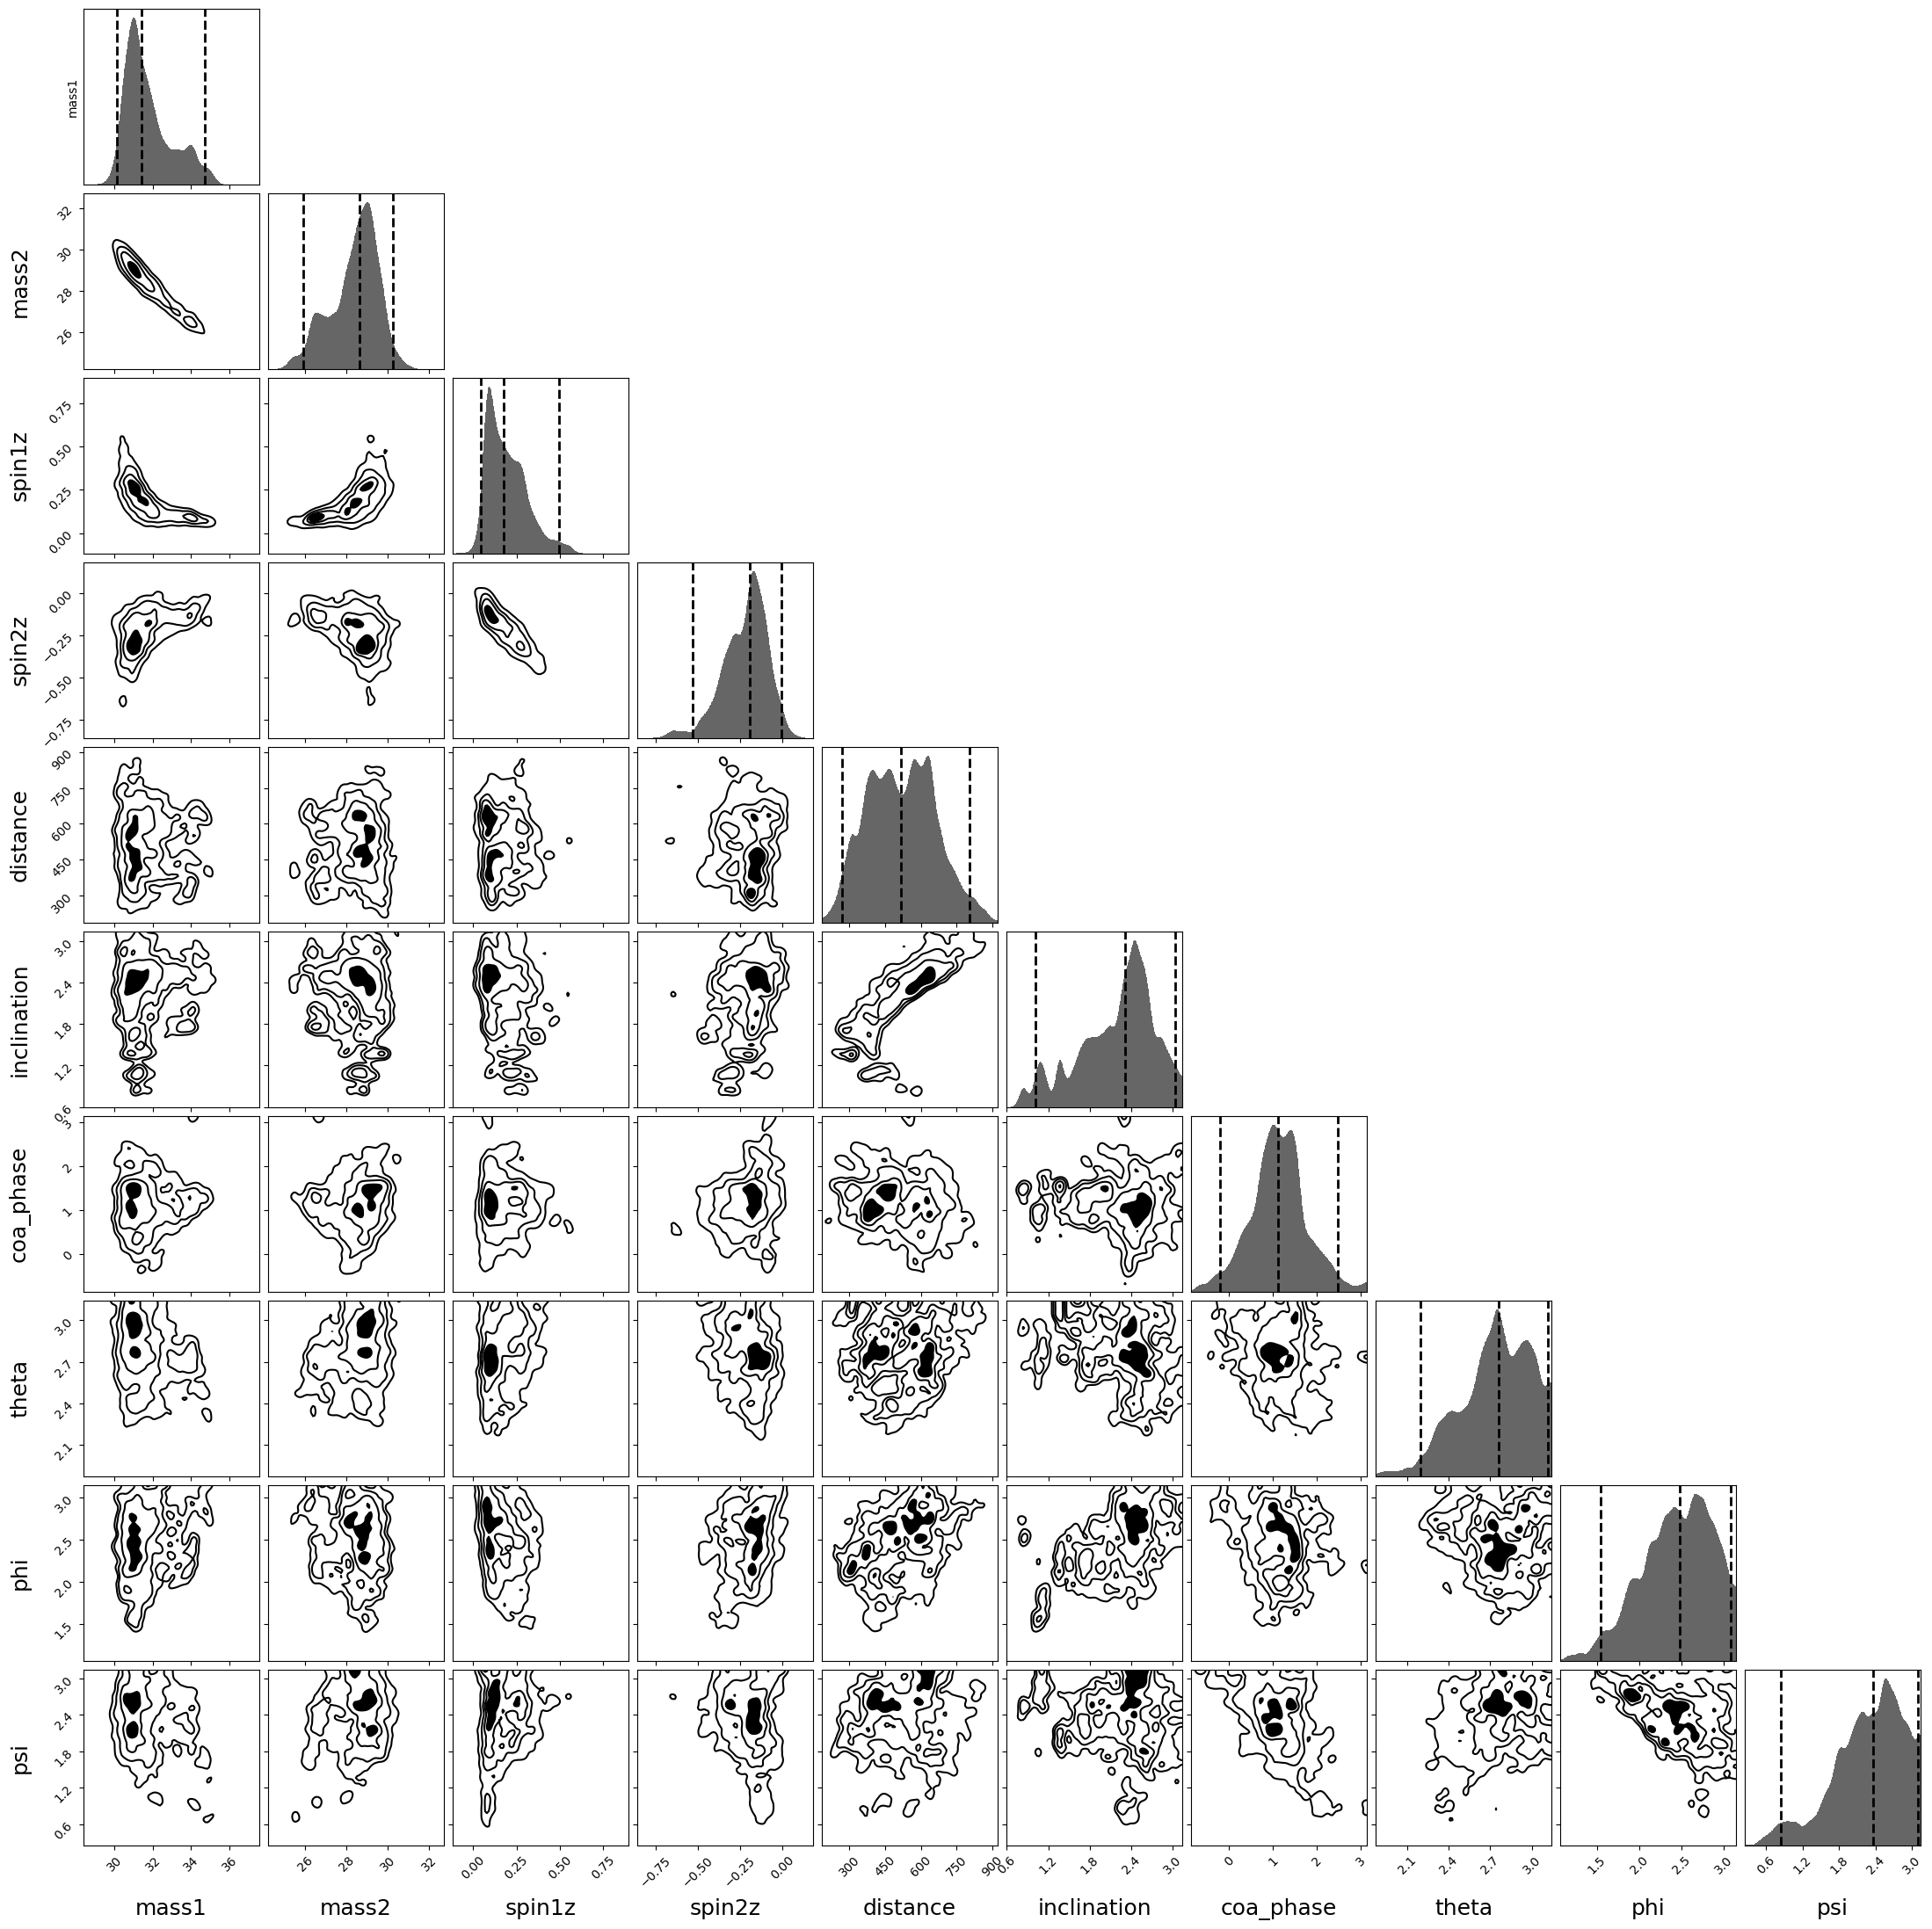

In [46]:
# visualize the results
# show max likelihood point and 90% credible interval
fig, axes = dyplot.cornerplot(results, 
                            #   show_titles=True, 
                            label_kwargs={"fontsize": 18},
                            title_kwargs={"fontsize": 18},
                            # edit the font size of axis labels
                            # hist_kwargs={"linewidth": 2, "color": "blue"},
)
# relable the axe

parameters = list(initial_params.keys())

for x in range (ndim):
    [axes[x, 0].set_ylabel(f'{parameters[x]}')]
    [axes[-1, x].set_xlabel(f'{parameters[x]}')]

# plt.savefig("figures/corner_plot.png")
plt.show()

In [47]:
# print estimated parameters and 90% credible intervals
for i, (param, mean_val) in enumerate(zip(parameters, mean)):
    print(f'{param}: {mean_val:.2f} +/- {np.sqrt(cov[i, i]):.2f}')

    

mass1: 31.76 +/- 1.24
mass2: 28.38 +/- 1.15
spin1z: 0.20 +/- 0.12
spin2z: -0.22 +/- 0.13
distance: 519.09 +/- 141.58
inclination: 2.19 +/- 0.54
coa_phase: 1.13 +/- 0.65
theta: 2.73 +/- 0.25
phi: 2.44 +/- 0.41
psi: 2.27 +/- 0.58


In [48]:
print(sampler.citations)

Code and Methods:
Speagle (2020): ui.adsabs.harvard.edu/abs/2020MNRAS.493.3132S
Koposov et al. (2023): doi.org/10.5281/zenodo.3348367

Nested Sampling:
Skilling (2004): ui.adsabs.harvard.edu/abs/2004AIPC..735..395S
Skilling (2006): projecteuclid.org/euclid.ba/1340370944


Bounding Method:
Feroz, Hobson & Bridges (2009): ui.adsabs.harvard.edu/abs/2009MNRAS.398.1601F

Sampling Method:
Skilling (2006): projecteuclid.org/euclid.ba/1340370944

